In [253]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Data Cleaning

In [254]:
df = pd.read_csv('cleaned_data.csv', sep=';')
df[['Byggeår','Rum', 'Toilet', 'Plan', 'Boligareal']] = df[['Byggeår','Rum', 'Toilet', 'Plan', 'Boligareal']] / 10
df = df.drop(columns=['Etage'])
df['Age'] = 2023 - df['Byggeår']

In [255]:
df = df.dropna()
df.shape

(3571, 26)

In [256]:
# Create dummy variables for the 'Category' column
dummy_df = pd.get_dummies(df['property_type'], prefix='property_type')
dummy = pd.get_dummies(df['heating_source'], prefix = '')

# Concatenate the dummy variables with the original DataFrame
df_with_dummies = pd.concat([df, dummy_df, dummy], axis=1)

In [257]:
df_with_dummies.columns

Index(['Byggeår', 'Rum', 'Toilet', 'Plan', 'Boligareal', 'Grundareal',
       'Kontantpris', 'Ejerudgift', 'distance to city', 'property_type',
       'heating_source', 'Energimærke_B', 'Energimærke_C', 'Energimærke_D',
       'Energimærke_E', 'Energimærke_F', 'Energimærke_G', 'Energimærke_nan',
       'Kælder_1', 'Garage_1', 'Drivhus_1', 'Erhverv_1', 'closest city_Aarhus',
       'closest city_Copenhagen', 'closest city_Odense', 'Age',
       'property_type_Fritidsbolig', 'property_type_Grund',
       'property_type_Lejlighed', 'property_type_Rækkehus',
       'property_type_Villa', '_clean_renewable', '_non_clean',
       '_non_renewable'],
      dtype='object')

In [258]:
# Function to remove the dot from strings with a decimal point
def remove_dot(value):
    if '.' in value:
        return value.replace('.', '')
    else:
        return value

# Apply the function to the 'Grundareal' column
df_with_dummies['Grundareal2'] = df_with_dummies['Grundareal'].apply(remove_dot)

In [259]:
df_with_dummies

,Byggeår,Rum,Toilet,Plan,Boligareal,Grundareal,Kontantpris,Ejerudgift,distance to city,property_type,...,Age,property_type_Fritidsbolig,property_type_Grund,property_type_Lejlighed,property_type_Rækkehus,property_type_Villa,_clean_renewable,_non_clean,_non_renewable,Grundareal2
0,1976.0,4.0,2.0,2.0,146.0,930,3495000.0,2979.0,6.309379e+15,Villa,...,47.0,0,0,0,0,1,0,0,1,930
1,1906.0,4.0,1.0,1.0,119.0,1.340,1795000.0,256.0,5.814809e+15,Lejlighed,...,117.0,0,0,1,0,0,1,0,0,1340
3,1998.0,5.0,2.0,1.0,145.0,802,2195000.0,2427.0,8.302623e+15,Villa,...,25.0,0,0,0,0,1,1,0,0,802
4,1959.0,7.0,2.0,2.0,241.0,935,3595000.0,3521.0,8.511158e+15,Villa,...,64.0,0,0,0,0,1,1,0,0,935
5,1963.0,4.0,1.0,1.0,100.0,940,1345000.0,1891.0,4.526230e+15,Villa,...,60.0,0,0,0,0,1,1,0,0,940
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4966,1932.0,3.0,1.0,3.0,131.0,1.804,645000.0,1402.0,9.600381e+15,Villa,...,91.0,0,0,0,0,1,1,0,0,1804
4968,1911.0,2.0,2.0,2.0,244.0,30.619,1995000.0,2255.0,9.065690e+15,Villa,...,112.0,0,0,0,0,1,0,1,0,30619
4969,2017.0,6.0,2.0,1.0,239.0,1.142,5995000.0,4931.0,6.015022e+16,Villa,...,6.0,0,0,0,0,1,1,0,0,1142
4970,1890.0,7.0,1.0,1.0,232.0,"3,1 ha",2300000.0,3099.0,7.723121e+15,Villa,...,133.0,0,0,0,0,1,1,0,0,"3,1 ha"


In [260]:
#df['Grundareal2'] = df['Grundareal'].str.replace('\.', '', regex=True)
df_with_dummies['Grundareal2'] = df_with_dummies['Grundareal2'].str.replace(',', '.')

def convert_to_square_meters(value):
    if isinstance(value, str):
        if ' ha' in value:
            try:
                ha_value = float(value.replace(' ha', ''))  # Remove ' ha' and convert to float
                return ha_value * 10000  # Conversion factor for hectares to square meters
            except:
                return None
        else:
            try:
                return float(value)
            except:
                return None
    else:
        return value

df_with_dummies['Grundareal3'] = df_with_dummies['Grundareal2'].apply(convert_to_square_meters)

In [261]:
df_with_dummies

,Byggeår,Rum,Toilet,Plan,Boligareal,Grundareal,Kontantpris,Ejerudgift,distance to city,property_type,...,property_type_Fritidsbolig,property_type_Grund,property_type_Lejlighed,property_type_Rækkehus,property_type_Villa,_clean_renewable,_non_clean,_non_renewable,Grundareal2,Grundareal3
0,1976.0,4.0,2.0,2.0,146.0,930,3495000.0,2979.0,6.309379e+15,Villa,...,0,0,0,0,1,0,0,1,930,930.0
1,1906.0,4.0,1.0,1.0,119.0,1.340,1795000.0,256.0,5.814809e+15,Lejlighed,...,0,0,1,0,0,1,0,0,1340,1340.0
3,1998.0,5.0,2.0,1.0,145.0,802,2195000.0,2427.0,8.302623e+15,Villa,...,0,0,0,0,1,1,0,0,802,802.0
4,1959.0,7.0,2.0,2.0,241.0,935,3595000.0,3521.0,8.511158e+15,Villa,...,0,0,0,0,1,1,0,0,935,935.0
5,1963.0,4.0,1.0,1.0,100.0,940,1345000.0,1891.0,4.526230e+15,Villa,...,0,0,0,0,1,1,0,0,940,940.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4966,1932.0,3.0,1.0,3.0,131.0,1.804,645000.0,1402.0,9.600381e+15,Villa,...,0,0,0,0,1,1,0,0,1804,1804.0
4968,1911.0,2.0,2.0,2.0,244.0,30.619,1995000.0,2255.0,9.065690e+15,Villa,...,0,0,0,0,1,0,1,0,30619,30619.0
4969,2017.0,6.0,2.0,1.0,239.0,1.142,5995000.0,4931.0,6.015022e+16,Villa,...,0,0,0,0,1,1,0,0,1142,1142.0
4970,1890.0,7.0,1.0,1.0,232.0,"3,1 ha",2300000.0,3099.0,7.723121e+15,Villa,...,0,0,0,0,1,1,0,0,3.1 ha,31000.0


In [151]:
#y = df_with_dummies['Kontantpris']
#X = df_with_dummies.drop(columns=['Kontantpris','property_type','heating_source','distance to city','Byggeår'])

# Machine learning models

In [353]:
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import r2_score
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso

In [354]:
y = df_with_dummies['Kontantpris']
X = df_with_dummies.drop(columns=['Kontantpris','property_type','heating_source', 'Grundareal2', 'Grundareal',
                                  'distance to city','Byggeår','_clean_renewable', '_non_clean',
                                  '_non_renewable', 'Energimærke_nan'])

In [355]:
X_dev, X_test, y_dev, y_test = train_test_split(X, y, test_size=1/4, random_state=10)
X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size=1/2, random_state=10)

## Linear Regression

In [380]:
pipe_lr = make_pipeline(PolynomialFeatures(degree=1, include_bias=False),
                        StandardScaler(),
                        LinearRegression())

pipe_lr.fit(X_train, y_train)
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

train_rmse = np.sqrt(mse(y_train, y_train_pred))
test_rmse = np.sqrt(mse(y_test, y_test_pred))
print(train_rmse,test_rmse)

1550782.581139418 1701632.5460633808


In [381]:
r2_linear = r2_score(y_test, y_test_pred)
r2_linear

0.5231429419004779

In [361]:
print(lr.coef_)

[ 123476.78046364  349375.31312377  -81918.26897091  350923.71687422
 1022752.34928191 -204961.66620117 -511928.83830814 -597093.45973978
 -454459.05532176 -359595.81819436 -218613.54707424  370722.63778102
   -5733.05244238  -72928.83365875  -64293.08761599  366713.1688809
  714895.62107888  170596.57206101  -22351.92199086 -198790.66656068
  -40573.69800921  169133.65190916   11803.91062562  -13968.61751922
   43558.72347574]


## Lasso

In [366]:
perform = [] # Store performance
lambdas = np.logspace(-8, 8, 10) # Grid of lambdas

# FOR EACH LAMBDA, FIT A MODEL ON TRAINING DATA, CHECK PERFORMANCE ON VALIDATION AND STORE MSE
for lambda_ in lambdas:
    pipe_lasso = make_pipeline(PolynomialFeatures(degree=1, include_bias=False), 
                               StandardScaler(),
                               Lasso(alpha=lambda_, random_state=161193))
    pipe_lasso.fit(X_train, y_train)
    y_pred = pipe_lasso.predict(X_val)
    perform.append(mse(y_pred, y_val))

# CRATE A SERIES WITH PERFORMANCE AND FIND PARM WITH LOWEST MSE    
hyperparam_perform = pd.Series(perform,index=lambdas)
optimal = hyperparam_perform.nsmallest(1)    
print('Optimal lambda:', optimal.index[0])
print('Validation MSE: %.3f' % optimal.values[0])

Optimal lambda: 1668100.5372000558
Validation MSE: 6208832190744.457


C:\Users\marko\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 18931217503644.0, tolerance: 709832139776.3524
  model = cd_fast.enet_coordinate_descent(
C:\Users\marko\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22116957926798.5, tolerance: 709832139776.3524
  model = cd_fast.enet_coordinate_descent(
C:\Users\marko\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22156626533242.5, tolerance: 709832139776.3524
  model = cd_fast.enet_coordinate_descent(
C:\Users\marko\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: 

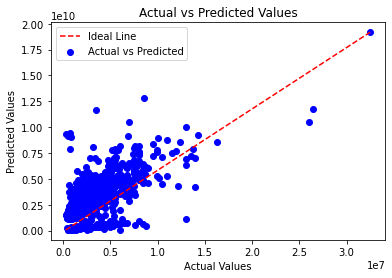

In [364]:
plt.scatter(y_val, y_pred, color='blue', label='Actual vs Predicted')
plt.plot([y_val.min(), y_val.max()], [y_pred.min(), y_pred.max()], linestyle='--', color='red', label='Ideal Line')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.show()

In [372]:
# Create an array of lambda values (logspace)
lambda_values = np.logspace(-8, 8, num=9)

# Initialize lists to store RMSE values
train_rmse_values = []
test_rmse_values = []

# Perform Lasso regression for each lambda
for lam in lambda_values:
    
    norm_scaler = StandardScaler().fit(X_train) 
    X_train = norm_scaler.transform(X_train) 
    X_test = norm_scaler.transform(X_test)
    
    lasso = Lasso(alpha=lam)
    lasso.fit(X_train, y_train)
    
    # Predict on train and test data
    y_train_pred = lasso.predict(X_train)
    y_test_pred = lasso.predict(X_test)
    
    # Calculate RMSE
    train_rmse = np.sqrt(mse(y_train, y_train_pred))
    test_rmse = np.sqrt(mse(y_test, y_test_pred))
    
    train_rmse_values.append(train_rmse)
    test_rmse_values.append(test_rmse)
    
    # Print fitted coefficients for each lambda
    print(f"Lambda = {lam:.6f}, MSE: {test_rmse_values}")

Lambda = 0.000000, MSE: [1701632.546063374]
Lambda = 0.000001, MSE: [1701632.546063374, 1701632.5460626876]
Lambda = 0.000100, MSE: [1701632.546063374, 1701632.5460626876, 1701632.545994009]
Lambda = 0.010000, MSE: [1701632.546063374, 1701632.5460626876, 1701632.545994009, 1701632.5391261412]
Lambda = 1.000000, MSE: [1701632.546063374, 1701632.5460626876, 1701632.545994009, 1701632.5391261412, 1701631.8523669988]
Lambda = 100.000000, MSE: [1701632.546063374, 1701632.5460626876, 1701632.545994009, 1701632.5391261412, 1701631.8523669988, 1701564.3120019927]
Lambda = 10000.000000, MSE: [1701632.546063374, 1701632.5460626876, 1701632.545994009, 1701632.5391261412, 1701631.8523669988, 1701564.3120019927, 1697572.3588912517]
Lambda = 1000000.000000, MSE: [1701632.546063374, 1701632.5460626876, 1701632.545994009, 1701632.5391261412, 1701631.8523669988, 1701564.3120019927, 1697572.3588912517, 2189208.193240932]
Lambda = 100000000.000000, MSE: [1701632.546063374, 1701632.5460626876, 1701632.545

C:\Users\marko\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22420850693468.0, tolerance: 709832139776.3524
  model = cd_fast.enet_coordinate_descent(
C:\Users\marko\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22162132445227.0, tolerance: 709832139776.3524
  model = cd_fast.enet_coordinate_descent(
C:\Users\marko\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 22157464833600.0, tolerance: 709832139776.3524
  model = cd_fast.enet_coordinate_descent(
C:\Users\marko\anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: 

## Ridge

In [373]:
from sklearn.linear_model import Ridge

pipe_ridge = make_pipeline(PolynomialFeatures(degree=2, include_bias=False), 
                           StandardScaler(),
                           Ridge(alpha=1, random_state=161193))
pipe_ridge.fit(X_train,y_train)
y_pred = pipe_ridge.predict(X_test)

# Calculate Mean Squared Error
print(mse(y_test, y_pred))

59887202818275.22


## Model Validation

Select optimal hypterparameters

In [375]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet

lambdas = np.logspace(-4, 4, 10) # Grid of lambdas

pipe_el = make_pipeline(PolynomialFeatures(degree=1, include_bias=False), 
                        StandardScaler(),
                        ElasticNet())

gs = GridSearchCV(estimator=pipe_el, 
                  param_grid={'elasticnet__alpha':lambdas,
                              'elasticnet__l1_ratio':np.linspace(0,1,10)}, 
                  scoring='neg_mean_squared_error', 
                  cv=10)

#gs.fit(X_dev, y_dev)
#print(mse(gs.predict(X_test),y_test))

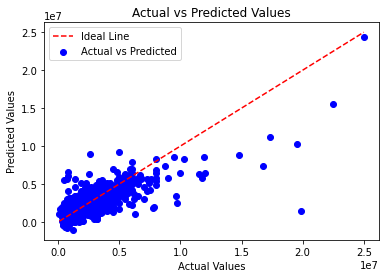

In [313]:
# Plot y_test vs y_pred
plt.scatter(y_test, y_test_pred, color='blue', label='Actual vs Predicted')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], linestyle='--', color='red', label='Ideal Line')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.show()

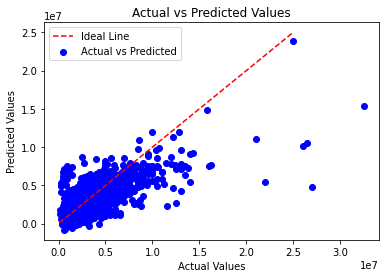

In [314]:
# Plot y_test vs y_pred
plt.scatter(y_train, y_train_pred, color='blue', label='Actual vs Predicted')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], linestyle='--', color='red', label='Ideal Line')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.show()

## Compare Models

### Compare R squared 

### Learning curves

In [383]:
# LOAD FROM SCIKIT-LEARN
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = \
    learning_curve(estimator=pipe_lr,
                   X=X_dev,
                   y=y_dev,
                   train_sizes=np.arange(0.05, 1.05, .05),
                   scoring='neg_mean_squared_error',                 
                   cv=10)
    
mse_ = pd.DataFrame({'Train':-train_scores.mean(axis=1),
                     'Test':-test_scores.mean(axis=1)})\
        .set_index(pd.Index(train_sizes,name='sample size'))

mse_.head(10)

,Train,Test
sample size,,
120,1.470712e+12,3.790331e+12
241,2.657525e+12,3.175828e+12
361,2.464225e+12,3.053736e+12
482,2.537333e+12,4.902697e+37
602,2.273987e+12,2.850030e+12
723,2.415788e+12,2.804413e+12
843,2.305496e+12,2.764248e+12
964,2.378395e+12,2.759801e+12
1084,2.375986e+12,2.746170e+12


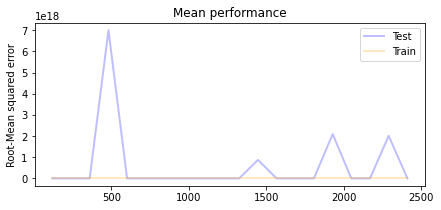

In [384]:
f_learn, ax = plt.subplots(figsize=(7,3))
ax.plot(train_sizes,np.sqrt(-test_scores.mean(1)), alpha=0.25, linewidth=2, label ='Test', color='blue') # negated, because we already use neg_MSE
ax.plot(train_sizes,np.sqrt(-train_scores.mean(1)), alpha=0.25, linewidth=2, label='Train', color='orange') # negated, because we already use neg_MSE

ax.set_title('Mean performance')
ax.set_ylabel('Root-Mean squared error')
ax.legend();

# Normal OLS for comparison

In [389]:
import pandas as pd
import numpy as np
import statsmodels.api as sm

# Add a constant term to X
X = sm.add_constant(X)

# Fit OLS regression model
model = sm.OLS(y, X).fit()

# Print regression summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:            Kontantpris   R-squared:                       0.544
Model:                            OLS   Adj. R-squared:                  0.541
Method:                 Least Squares   F-statistic:                     176.4
Date:                Tue, 15 Aug 2023   Prob (F-statistic):               0.00
Time:                        15:34:04   Log-Likelihood:                -56147.
No. Observations:                3571   AIC:                         1.123e+05
Df Residuals:                    3546   BIC:                         1.125e+05
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const               

C:\Users\marko\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
